In [1]:
import keras
import keras.layers as layers

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [4]:
from keras import backend as k_backend

def sampling(args):
    mean, log_sigma = args
    epsilon = k_backend.random_normal(shape=(k_backend.shape(mean)[0], latent_dim),
                                      mean=0., stddev=0.1)
    return mean + k_backend.exp(log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [5]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [6]:
from keras.losses import binary_crossentropy

reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - k_backend.square(z_mean) - k_backend.exp(z_log_sigma)
kl_loss = k_backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = k_backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [8]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 6s 3ms/step - loss: 187.6851 - val_loss: 169.0413
Epoch 2/100
1875/1875 [==============================] - 3s 2ms/step - loss: 165.8897 - val_loss: 163.4139
Epoch 3/100
1875/1875 [==============================] - 3s 2ms/step - loss: 161.8285 - val_loss: 160.5681
Epoch 4/100
1875/1875 [==============================] - 3s 2ms/step - loss: 159.4971 - val_loss: 158.7268
Epoch 5/100
1875/1875 [==============================] - 3s 2ms/step - loss: 157.9783 - val_loss: 157.6566
Epoch 6/100
1875/1875 [==============================] - 3s 2ms/step - loss: 156.8287 - val_loss: 156.5756
Epoch 7/100
1875/1875 [==============================] - 3s 2ms/step - loss: 155.9821 - val_loss: 156.0707
Epoch 8/100
1875/1875 [==============================] - 3s 2ms/step - loss: 155.2586 - val_loss: 155.3902
Epoch 9/100
1875/1875 [==============================] - 3s 2ms/step - loss: 154.6638 - val_loss: 155.0389
Epoch 10/100
1875/1875 [=============

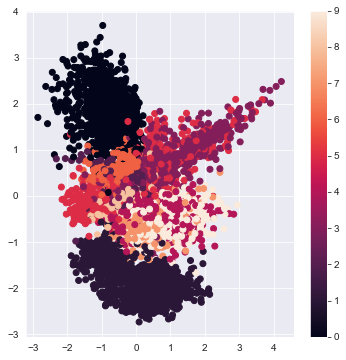

In [20]:
import matplotlib.pyplot as plt

batch_size=64

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0].T[0], x_test_encoded[0].T[1], c=y_test)
plt.colorbar()

plt.show()

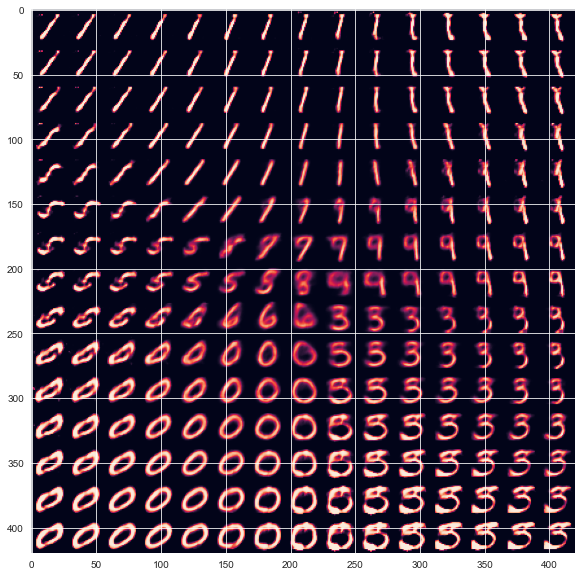

In [24]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-5, 5] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('figures/variational_autoencoder_results.png', dpi=250)
plt.show()